In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torch import nn, optim
from torchvision import models, datasets, transforms
import torch
import torchvision
import torch.nn.functional as F
from voxel_data_generator import SSL_Dataset
from sklearn.decomposition import PCA

In [2]:
class ConvNet_module(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv3d(1, 64, kernel_size=3, stride=1, bias=False, padding=1)
        self.conv2 = nn.Conv3d(64, 128, kernel_size=3, stride=1, bias=False, padding=1)
        self.conv3 = nn.Conv3d(128, 256, kernel_size=3, stride=1, bias=False, padding=1)
        self.conv4 = nn.Conv3d(256, 512, kernel_size=3, stride=1, bias=False, padding=1)
        self.conv5 = nn.Conv3d(512, 1024, kernel_size=3, stride=1, bias=False, padding=1)
        self.bn1 = nn.BatchNorm3d(64)
        self.bn2 = nn.BatchNorm3d(128)
        self.bn3 = nn.BatchNorm3d(256)
        self.bn4 = nn.BatchNorm3d(512)
        self.bn5 = nn.BatchNorm3d(1024)
        self.pool1 = nn.MaxPool3d(2)
        self.pool2 = nn.MaxPool3d(2)
        self.pool3 = nn.MaxPool3d(2)
        self.pool4 = nn.MaxPool3d(2)
        self.pool5 = nn.AvgPool3d(4)
        self.fc = nn.Linear(1024,128)
        self.out = nn.Linear(128,1)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool4(x)
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool5(x)
        x = torch.squeeze(x)
        x = self.out(F.relu(self.fc(x)))
        return x

In [3]:
def high_level_feature(model, x):
    x = F.relu(model.bn1(model.conv1(x)))
    x = model.pool1(x)
    x = F.relu(model.bn2(model.conv2(x)))
    x = model.pool2(x)
    x = F.relu(model.bn3(model.conv3(x)))
    x = model.pool3(x)
    x = F.relu(model.bn4(model.conv4(x)))
    x = model.pool4(x)
    x = F.relu(model.bn5(model.conv5(x)))
    x = model.pool5(x)
    x = torch.squeeze(x)
    print(x.shape)
    return x

In [4]:
def main():
    model = ConvNet_module().cuda()
    state_dict = torch.load('bumpSSL500_0922.pth', map_location='cpu')
    model.load_state_dict(state_dict, strict=False)
    
    # Data loading
    train_dataset = SSL_Dataset(train=True)
    val_dataset = SSL_Dataset(train=False)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=64, num_workers=2,
        pin_memory=True, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, num_workers=2)
    features = []
    res = []
    for inputs, labels in val_loader:
            y_pred = high_level_feature(model, inputs.cuda())
            features = y_pred.cpu().detach().numpy()
            res = labels
    var = np.var(features, axis=0)
    plt.bar(np.arange(1024), var, width=1)
    plt.xlabel('feature index', fontsize=18)
    plt.ylabel('variance', fontsize=18)
    plt.ylim([0, 0.01])
    plt.show()
    plt.close()
    pca = PCA(n_components=2)
    features_2 = pca.fit_transform(features)
    print(pca.explained_variance_ratio_)
    plt.scatter(features_2[:, 0], features_2[:, 1], c=res, cmap='Reds')
    plt.xlabel('PC1', fontsize=18)
    plt.ylabel('PC2', fontsize=18)
    plt.colorbar()
    plt.show()
    plt.close()
    
    state_dict = torch.load('bumpSup_0922.pth', map_location='cpu')
    model.load_state_dict(state_dict, strict=False)
    features = []
    for inputs, labels in val_loader:
            y_pred = high_level_feature(model, inputs.cuda())
            features = y_pred.cpu().detach().numpy()
            res = labels
    var = np.var(features, axis=0)
    plt.bar(np.arange(1024), var, width=1)
    plt.xlabel('feature index', fontsize=18)
    plt.ylabel('variance', fontsize=18)
    plt.ylim([0, 0.01])
    plt.show()
    plt.close()
    features_2 = pca.fit_transform(features)
    print(pca.explained_variance_ratio_)
    plt.scatter(features_2[:, 0], features_2[:, 1], c=res, cmap='Reds')
    plt.xlabel('PC1', fontsize=18)
    plt.ylabel('PC2', fontsize=18)
    plt.colorbar()
    plt.show()
    plt.close()


torch.Size([30, 1024])


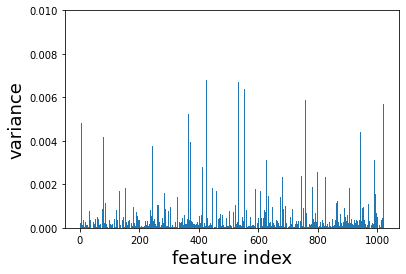

[0.32674405 0.23047443]


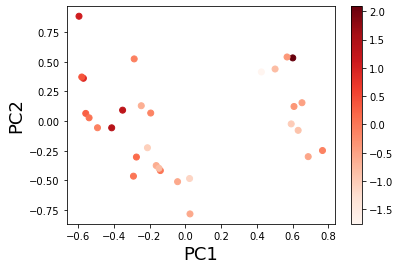

torch.Size([30, 1024])


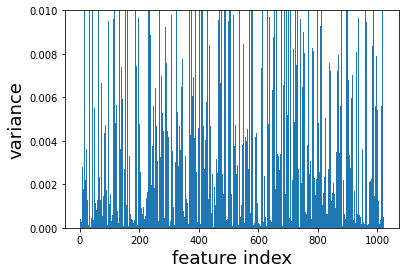

[0.90860313 0.0382769 ]


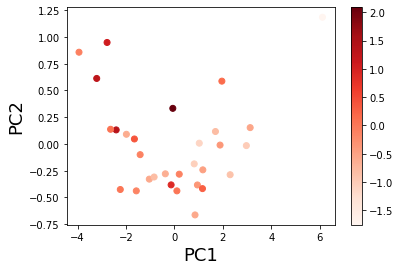

In [5]:
if __name__ == '__main__':
    main()